# RMS Prop

The problem with autograd? It's learning rate decreases monotonically, where at one point it becomes zero due to the aggresive squaring of gradients.
Extremely similar to adagrad, except instead of squared gradients it uses a exponentially moving average.

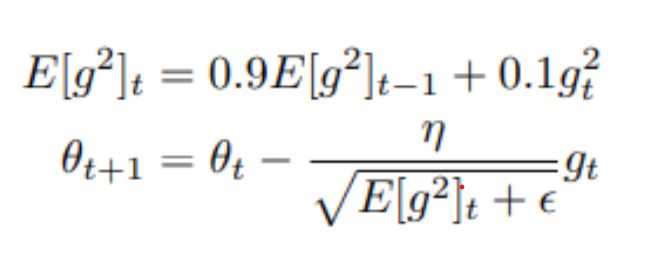


Hinton suggests γ to be set to 0.9, while a good default value for the learning rate η is 0.001.

In [11]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42) # for reproducibility

In [3]:
# initializing hyperparameters
n_hidden = 64
n_classes = 10
batch_size = 64
learning_rate = 0.01
num_epochs = 10

In [4]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(), # converts each image (28×28) into a PyTorch tensor with values [0,1].
    transforms.Normalize((0.1307,), (0.3081,)) # standard normalization
])

In [6]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.96MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.97MB/s]


In [7]:
# defining the model
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, n_hidden)
    self.fc2 = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = SimpleNet()

In [8]:
# Initialze weights as per our example
g = torch.Generator().manual_seed(2024)

model.fc1.weight.data = torch.randn((n_hidden, 28 * 28), generator=g) * 0.1
model.fc1.bias.data = torch.randn(n_hidden, generator=g) * 0.1

model.fc2.weight.data = torch.randn((n_classes, n_hidden), generator=g) * 0.1
model.fc2.bias.data = torch.randn(n_classes, generator=g) * 0.1

parameters = list(model.parameters())

In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = learning_rate, alpha = 0.90)

In [13]:
train_losses = []
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        train_losses.append(loss.item())

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    print("-------------------------------")

Epoch 1/10, Batch 0/938, Loss: 3.4365
Epoch 1/10, Batch 100/938, Loss: 0.2401
Epoch 1/10, Batch 200/938, Loss: 0.3554
Epoch 1/10, Batch 300/938, Loss: 0.4856
Epoch 1/10, Batch 400/938, Loss: 0.3650
Epoch 1/10, Batch 500/938, Loss: 0.4732
Epoch 1/10, Batch 600/938, Loss: 0.2456
Epoch 1/10, Batch 700/938, Loss: 0.2777
Epoch 1/10, Batch 800/938, Loss: 0.9372
Epoch 1/10, Batch 900/938, Loss: 0.3646
Epoch 1/10, Average Loss: 0.3474
-------------------------------
Epoch 2/10, Batch 0/938, Loss: 0.4541
Epoch 2/10, Batch 100/938, Loss: 0.3518
Epoch 2/10, Batch 200/938, Loss: 0.1073
Epoch 2/10, Batch 300/938, Loss: 0.3417
Epoch 2/10, Batch 400/938, Loss: 0.3689
Epoch 2/10, Batch 500/938, Loss: 0.0798
Epoch 2/10, Batch 600/938, Loss: 0.3291
Epoch 2/10, Batch 700/938, Loss: 0.4599
Epoch 2/10, Batch 800/938, Loss: 0.1045
Epoch 2/10, Batch 900/938, Loss: 0.3472
Epoch 2/10, Average Loss: 0.2571
-------------------------------
Epoch 3/10, Batch 0/938, Loss: 0.2742
Epoch 3/10, Batch 100/938, Loss: 0.4

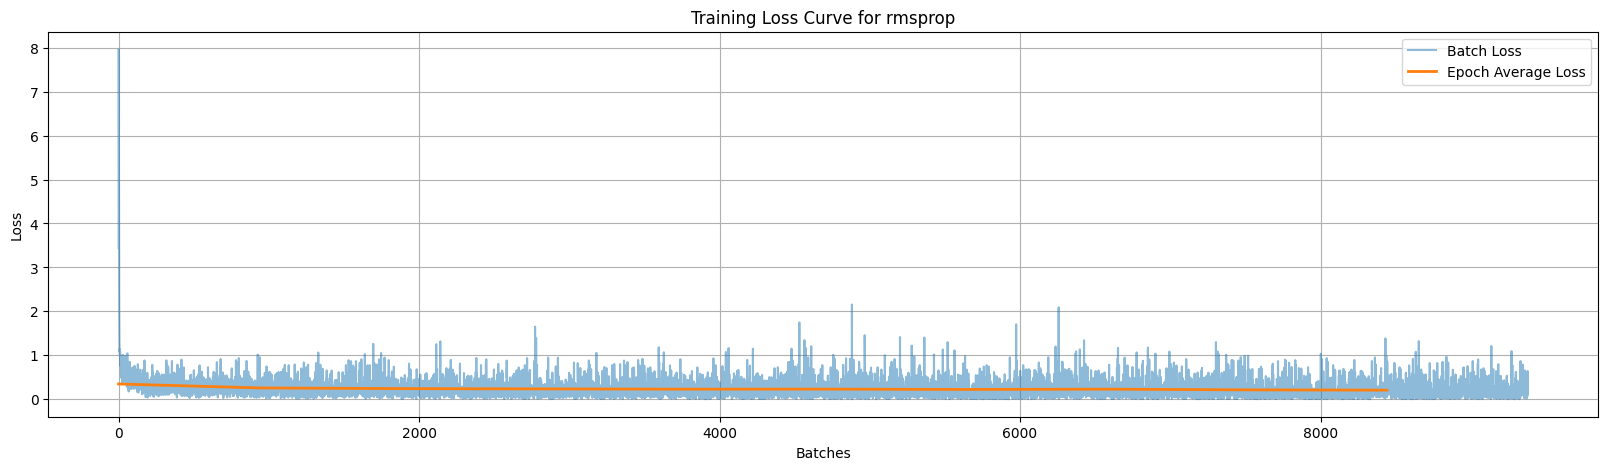

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(train_losses, label='Batch Loss', alpha=0.5)
plt.plot(range(0, len(train_losses), len(train_loader)), epoch_losses, label='Epoch Average Loss', linewidth=2)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss Curve for rmsprop')
plt.legend()
plt.grid(True)